In [93]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
nltk_data_dir = r'c:\\Users\\Admin\\anaconda3\\nltk_data'
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download('averaged_perceptron_tagger_eng', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)



[nltk_data] Downloading package punkt to
[nltk_data]     c:\\Users\\Admin\\anaconda3\\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\\Users\\Admin\\anaconda3\\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     c:\\Users\\Admin\\anaconda3\\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\\Users\\Admin\\anaconda3\\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     c:\\Users\\Admin\\anaconda3\\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('AA_movie_train_data.csv')

In [4]:
df.head()

,Title,Genre,Description
0,Windup (2006),action,Windup is a very original comedy. We follow B...
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...


In [5]:
df['Genre'].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

In [6]:
df['Description'][0]

' Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick\'s life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn\'t get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie\'s girlfriend Latrice and roommate Stuart only accentuate Bernie\'s seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie becau

In [7]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
from nltk.corpus import wordnet

In [60]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords

def get_stop_words(stop_file_path, include_spanish=True):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        custom_stopwords.update(spanish_stopwords)
    
    return frozenset(custom_stopwords)

In [273]:
from unidecode import unidecode

def clean_text(text):
    text = unidecode(text)                     # strip accents
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [275]:
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)

In [63]:
def get_wordnet_pos(treebank_tag):
    """Convert TreeBank POS tags to WordNet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


In [64]:
from nltk.stem import WordNetLemmatizer

def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  # You already have this function
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas


In [ ]:
stopwords = get_stop_words("stopwords.txt", include_spanish=True)

# 🔹 3. Full processing pipeline function
def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)

# 🔹 4. Apply to DataFrame
# Apply function and unpack results
df[['description_tokens', 'description_string']] = df['Description'].apply(
    lambda x: pd.Series(full_text_pipeline(x, stopwords))
)

description_tokens = df['description_tokens']
description_string = df['description_string']
df[['description_string']].to_csv('processed_descriptions.csv', index=False)

In [208]:
description_tokens[0]

['windup',
 'original',
 'comedy',
 'follow',
 'bernie',
 'shaddick',
 'tragic',
 'childhood',
 'day',
 'pursuit',
 'career',
 'inventor',
 'liken',
 'film',
 'raise',
 'arizona',
 'lebowski',
 'gritty',
 'cohen',
 'esque',
 'humor',
 'saturate',
 'bernie',
 'shaddick',
 'life',
 'encounter',
 'mace',
 'potential',
 'sale',
 'murderous',
 'mentor',
 'pose',
 'aunt',
 'audre',
 'uncle',
 'reg',
 'bernie',
 'rejection',
 'ridicule',
 'doesn',
 'persevere',
 'anyways',
 'nature',
 'nerve',
 'cruel',
 'co',
 'worker',
 'commercial',
 'real',
 'estate',
 'day',
 'job',
 'uphold',
 'delusional',
 'enthusiasm',
 'bernie',
 'unknowingly',
 'sell',
 'soul',
 'smile',
 'bernie',
 'girlfriend',
 'latrice',
 'roommate',
 'stuart',
 'accentuate',
 'bernie',
 'seemingly',
 'pathetic',
 'existence',
 'latrice',
 'sexy',
 'dirty',
 'sort',
 'love',
 'bernie',
 'prefer',
 'love',
 'money',
 'stuart',
 'usually',
 'clothe',
 'underpants',
 'obsess',
 'rubix',
 'cube',
 'live',
 'bernie',
 'allow',
 'pur

In [209]:
description_string[0]

'windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gra

In [210]:
description_string.shape

(5000,)

In [277]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.8, max_features=10000)
description_bow_matrix = bow_vectorizer.fit_transform(description_string.tolist())

In [278]:
# Try different values and see vocabulary size
for max_df_val in [0.15, 0.3, 0.5, 0.7, 0.9]:
    cv = CountVectorizer(max_df=max_df_val)
    cv.fit(description_string)
    print(f"max_df={max_df_val}: {len(cv.vocabulary_)} unique words")

max_df=0.15: 33540 unique words
max_df=0.3: 33551 unique words
max_df=0.5: 33552 unique words
max_df=0.7: 33552 unique words
max_df=0.9: 33552 unique words


In [279]:
sum_words = description_bow_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [280]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('life', 2830),
 ('film', 1638),
 ('family', 1414),
 ('world', 1414),
 ('story', 1413),
 ('friend', 1378),
 ('time', 1320),
 ('love', 1245),
 ('woman', 1110),
 ('day', 1076),
 ('live', 1025),
 ('people', 962),
 ('kill', 945),
 ('try', 903),
 ('own', 900),
 ('father', 886),
 ('girl', 879),
 ('leave', 847),
 ('meet', 824),
 ('help', 798)]

In [282]:
print('The lowest frequency words:')
words_freq[-20:] 

The lowest frequency words:


[('ishika', 4),
 ('karacadag', 4),
 ('walpurgis', 4),
 ('littleton', 4),
 ('haddonfield', 4),
 ('marksman', 4),
 ('fazbear', 4),
 ('soledad', 4),
 ('workman', 4),
 ('arif', 4),
 ('rangrao', 4),
 ('fujii', 4),
 ('helder', 4),
 ('gacy', 4),
 ('ragini', 4),
 ('nickie', 4),
 ('hideki', 4),
 ('pj', 4),
 ('fredrickson', 4),
 ('blaylock', 4)]

In [283]:
bow_vectorizer.get_feature_names_out()

array(['aaron', 'aarti', 'aarumugam', ..., 'zubaida', 'zulu', 'zum'],
      dtype=object)

In [284]:
feature_names=np.array(bow_vectorizer.get_feature_names_out())
len(bow_vectorizer.get_feature_names_out())

10000

In [285]:
pd.DataFrame(description_bow_matrix.toarray())

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
df_bow = pd.DataFrame(description_bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
df_bow.to_csv('asg1_bow_export.csv', index=False)

### 1.4 TF-IDF

In [287]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
description_tfidf = tfidf_transformer.fit_transform(description_bow_matrix)

In [288]:
tfidf_transformer.idf_

array([7.1194979 , 7.7256337 , 8.82424599, ..., 8.82424599, 8.13109881,
       7.90795526])

In [289]:
tfidf_transformer.idf_.shape

(10000,)

In [290]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['life' 'time' 'story' 'world' 'film' 'friend' 'family' 'love' 'day'
 'live' 'own' 'woman' 'try' 'people' 'meet' 'leave' 'help' 'kill' 'begin'
 'start' 'home' 'father' 'decide' 'lead' 'girl' 'follow' 'force' 'look'
 'wife' 'death' 'set' 'name' 'tell' 'bring' 'mother' 'city' 'run' 'soon'
 'fall' 'call' 'fight' 'child' 'daughter' 'police' 'return' 'change'
 'night' 'brother' 'discover' 'town' 'murder' 'lose' 'local' 'house'
 'past' 'documentary' 'secret' 'plan' 'learn' 'play' 'school' 'move'
 'dream' 'job' 'journey' 'save' 'series' 'money' 'happen' 'struggle'
 'relationship' 'movie' 'include' 'real' 'country' 'war' 'escape' 'hand'
 'head' 'win' 'die' 'character' 'event' 'american' 'attempt' 'realize'
 'break' 'sister' 'husband' 'boy' 'dead' 'student' 'bad' 'stop' 'power'
 'human' 'age' 'team' 'true' 'little']


In [291]:
pd.DataFrame(description_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
# find maximum value for each of the features over dataset:
max_value = description_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['faraway' 'unsuccessfully' 'stratum' 'delle' 'cbs' 'wheeling' 'angst'
 'fra' 'peterson' 'gallows' 'macho' 'pseudo' 'grandeur' 'plea' 'rigid'
 'lakh' 'ruffian' 'insure' 'rajasthan' 'auger']
Features with highest tfidf: 
['salak' 'desta' 'midyat' 'flint' 'raghuveer' 'bantu' 'greenock' 'deli'
 'jonathon' 'yoga' 'yanagi' 'kentaro' 'devin' 'cappuccino' 'laundry'
 'sreeram' 'aparna' 'juan' 'wine' 'comme']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [323]:
idx=0
doc = description_string[idx]
print(doc)

tf_idf_vector=description_tfidf[idx]
print(tf_idf_vector)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [324]:
tf_idf_vector.shape

(1, 10000)

In [325]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

,feature_number,tf_idf
0,101,0.031648
1,273,0.032484
2,476,0.045942
3,614,0.167229
4,825,0.041078
...,...,...
115,9759,0.095105
116,9774,0.042923
117,9855,0.051601
118,9865,0.063409


In [326]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

,feature_number,tf_idf
5,884,0.825146
3,614,0.167229
45,3346,0.162928
111,9293,0.139647
89,7222,0.100247
...,...,...
48,3689,0.021351
109,9218,0.019505
65,5242,0.018780
41,3173,0.018224


In [327]:
#use only topn items from vector
topn = 20
topn_items = temp[:topn]

tf_idf = []
word = []

for index, row in topn_items.iterrows():
    fname = feature_names[int(row['feature_number'])]
    word.append(fname)
    tf_idf.append(round(row['tf_idf'], 3))    

In [328]:
print(doc, '\n')

result = dict(zip(word, tf_idf))
print(result)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [329]:
topn = 20
results =[]

In [330]:
for idx, doc in description_string.items():
    #generate tf-idf for the given document
    tf_idf_vector=description_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    
    results.append(result)


In [331]:
len(results)

5000

In [332]:
df['keywords'] = results
df.head()

,Title,Genre,Description,description_tokens,description_string,keywords
0,Windup (2006),action,Windup is a very original comedy. We follow B...,"[windup, original, comedy, follow, bernie, sha...",windup original comedy follow bernie shaddick ...,"{'bernie': 0.825, 'aunt': 0.167, 'flashlight':..."
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ...","[rana, shuvo, sibling, father, police, constab...",rana shuvo sibling father police constable dea...,"{'shuvo': 0.789, 'rana': 0.404, 'brother': 0.1..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...,"[san, francisco, detective, hunt, cruel, asian...",san francisco detective hunt cruel asian crime...,"{'choy': 0.527, 'nelson': 0.425, 'shipment': 0..."
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i...","[name, lam, pick, girlfriend, reveal, girlfrie...",name lam pick girlfriend reveal girlfriend act...,"{'lam': 0.741, 'gangster': 0.385, 'martial': 0..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...,"[thap, homeless, musician, brother, village, r...",thap homeless musician brother village raid kh...,"{'thap': 0.54, 'khun': 0.516, 'ram': 0.5, 'pri..."


### 2.2 Association Rules Mining on keywords

In [333]:
transactions = [list(d.keys()) for d in results]
print(transactions)

[['bernie', 'aunt', 'flashlight', 'uncle', 'real', 'stuart', 'welfare', 'cuban', 'invent', 'mentor', 'product', 'commercial', 'pose', 'estate', 'co', 'worker', 'deal', 'mace', 'botched', 'cube'], ['shuvo', 'rana', 'brother', 'crime', 'constable', 'superintendent', 'bravery', 'extent', 'police', 'shower', 'tall', 'tackle', 'promote', 'villain', 'arise', 'assume', 'sibling', 'brave', 'onto', 'assist'], ['choy', 'nelson', 'shipment', 'violent', 'detective', 'asian', 'francisco', 'device', 'san', 'terrorist', 'center', 'capture', 'partner', 'steal', 'gang', 'convoy', 'lapd', 'art', 'chinatown', 'priceless'], ['lam', 'gangster', 'martial', 'artist', 'girlfriend', 'brother', 'kill', 'furious', 'fight', 'trap', 'reveal', 'unsuccessfully', 'enraged', 'stab', 'protection', 'guilty', 'lay', 'double', 'brutal', 'pick'], ['thap', 'khun', 'ram', 'prince', 'kingdom', 'village', 'concubine', 'plan', 'controversy', 'residence', 'stir', 'raid', 'villager', 'meet', 'frame', 'homeless', 'musician', 'dete

In [334]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

te = TransactionEncoder()
data_encoded = te.fit_transform(transactions)
data_encoded = pd.DataFrame(data_encoded, columns=te.columns_)

data_encoded.shape

(5000, 10000)

In [347]:
# Step 1: Count how often each keyword appears across all transactions
keyword_freq = data_encoded.sum(axis=0)

top_keywords = keyword_freq[keyword_freq >= 5]  # appears in at least 30 movies
selected_keywords = top_keywords.sort_values(ascending=False).head(200).index

In [348]:
data_encoded_filtered = data_encoded[selected_keywords]


In [349]:
# Create a DataFrame of keywords and their frequencies
#top_keywords_df = keyword_freq[top_200_keywords].reset_index()
#top_keywords_df.columns = ['Keyword', 'Frequency']

# Export to CSV
#top_keywords_df.to_csv('top_200_keywords.csv', index=False)


In [350]:
print(data_encoded.sum(axis=1).mean())

19.9752


In [351]:
data_encoded_filtered.shape

(5000, 200)

In [352]:
data_encoded_filtered

,film,family,life,woman,girl,friend,father,brother,love,mother,...,hero,experiment,professor,witch,struggle,trip,ll,military,age,crew
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: title={'center': 'Keyword Frequency Distribution'}, ylabel='Frequency'>

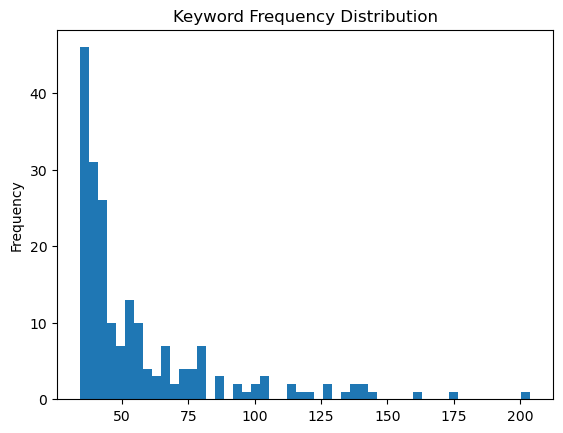

In [353]:
keyword_counts = data_encoded_filtered.sum().sort_values(ascending=False)
keyword_counts.plot(kind='hist', bins=50, title="Keyword Frequency Distribution")

In [354]:
for support in [0.05, 0.01, 0.005, 0.003, 0.002]:
    itemsets = apriori(data_encoded_filtered, min_support=support, use_colnames=True)
    print(f"Support: {support}, Itemsets: {itemsets.shape[0]}")

Support: 0.05, Itemsets: 0
Support: 0.01, Itemsets: 85
Support: 0.005, Itemsets: 200
Support: 0.003, Itemsets: 206
Support: 0.002, Itemsets: 247


In [355]:
frequent_itemsets=apriori(data_encoded_filtered, min_support = 0.005, use_colnames = True)

In [356]:
frequent_itemsets[['support']].describe()

,support
count,200.000000
mean,0.011332
std,0.005927
min,0.006800
25%,0.007600
50%,0.008800
75%,0.012850
max,0.040800


In [357]:
frequent_itemsets

,support,itemsets
0,0.0408,(film)
1,0.0350,(family)
2,0.0320,(life)
3,0.0290,(woman)
4,0.0282,(girl)
...,...,...
195,0.0068,(trip)
196,0.0068,(ll)
197,0.0068,(military)
198,0.0068,(age)


In [359]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
